In [1]:
import pandas as pd
import numpy as np
from graph_data import GraphData
from IPython.display import display

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
from dtaidistance import clustering
from vega import VegaLite
from vega import utils

# import matplotlib.pyplot as plt 
import scipy.sparse
import matplotlib.pyplot as plt 
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [2]:

# path = "../../vast/MC1/data/"
path = "../data/"

nodes_file_template = "CGCS-Template-NodeTypes.csv"
edges_file_template = "CGCS-Template"

graphs={}

graph = GraphData()
graph.read_data(nodes_file=nodes_file_template, edges_file=edges_file_template+".csv", path=path)
graphs[edges_file_template] = graph


stList = graph.edges.stType.unique()

nodes_file = "CGCS-GraphData-NodeTypes.csv"
graph_names = ["Q1-Graph1", "Q1-Graph2", "Q1-Graph3", "Q1-Graph4", "Q1-Graph5"]

for name in graph_names:
    graph = GraphData()
    graph.read_data(nodes_file=nodes_file, edges_file=name+".csv", path=path, stList=stList)
    graphs[name] = graph
#     # replace travel target
#     masktravel =  graphs[name].edges_no_financial.eType=='Travels-to'
#     graphs[name].edges_no_financial.loc[masktravel,"Target"] = graphs[name].edges_no_financial.loc[masktravel,"TargetLocation"] 


In [3]:
# import json

# with open('locations.json', 'w') as f:
#     json.dump(array_elems, f)

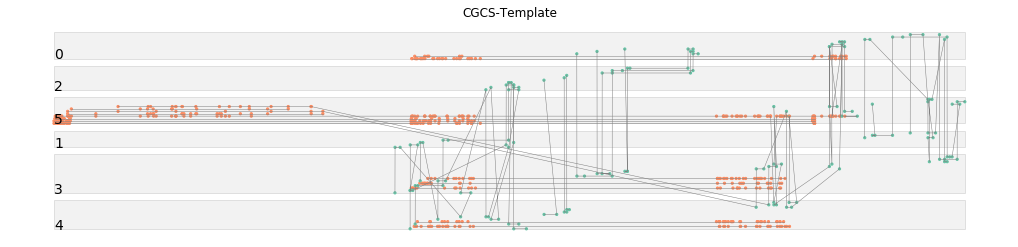

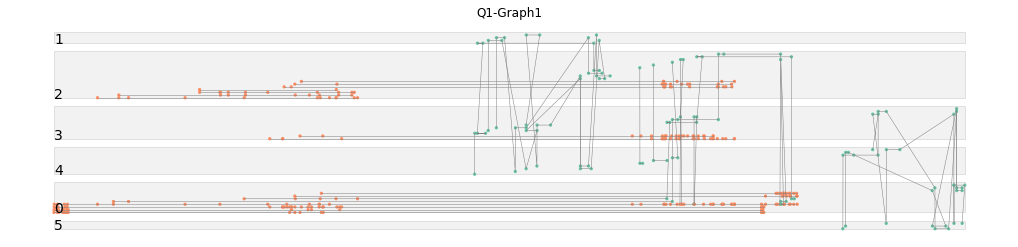

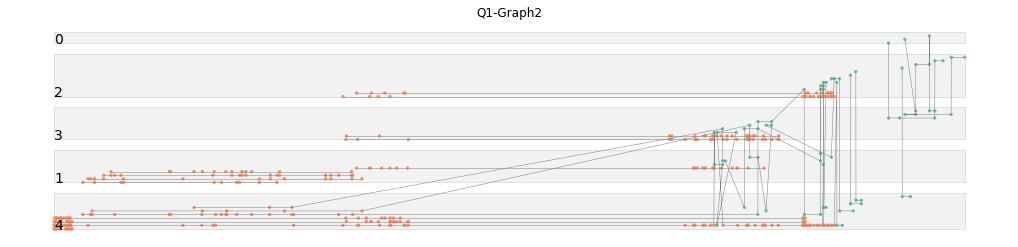

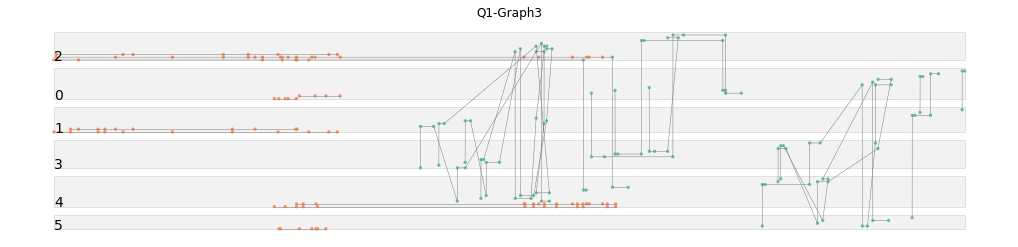

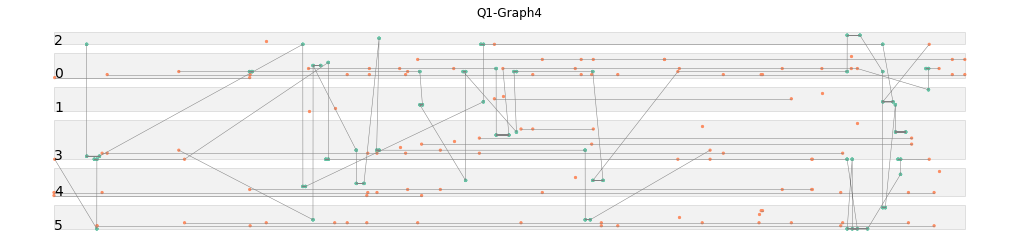

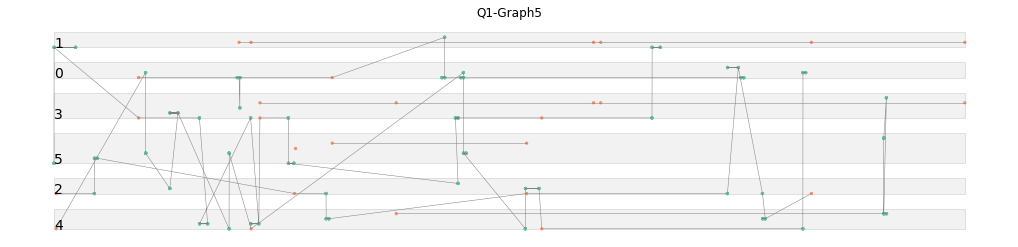

In [5]:
gi = 0
for name, graph in graphs.items():
    array_elems = []

    str_frmt = "%Y-%m-%d %H:%M:%S"
    # convert_time = lambda t: int((t.date().timestamp()))#-pd.Timestamp('2025-01-01').timestamp()))
    convert_time = lambda t: int((t-pd.Timestamp('2025-01-01')).total_seconds()/(60*60))

    for index, row in graph.edges_no_financial.iterrows():
        if row.SourceLocation != -1:
            if row.eType == 'Phone':
                el = {'Person': row.Source,
                      'Date': row.Time.strftime(str_frmt),
                      'TimeStamp': convert_time(row.Time),
                      'Location': row.SourceLocation,
                      'eType': row.eType
                     }
                array_elems.append(el)

            if row.eType == 'Travels-to':
                el = {'Person': row.Source,
                      'Date': (row.Time - pd.Timedelta(hours=2)).strftime(str_frmt),
                      'TimeStamp': convert_time(row.Time - pd.Timedelta(hours=1)),
                      'Location': row.SourceLocation,
                      'eType': row.eType
                     }
                array_elems.append(el)

        if row.TargetLocation != -1:
            if row.eType == 'Phone':
                el = {'Person': row.Target,
                      'Date': row.Time.strftime(str_frmt),
                      'TimeStamp': convert_time(row.Time),
                      'Location': row.TargetLocation,
                      'eType': row.eType
                     }
                array_elems.append(el)

            if row.eType == 'Travels-to':
                el = {'Person': row.Source,
                      'Date': row.Time.strftime(str_frmt),
                      'TimeStamp': convert_time(row.Time),
                      'Location': row.TargetLocation,
                      'eType': row.eType
                     }
                array_elems.append(el)
            
                el = {'Person': row.Source,
                      'Date': row.Time.strftime(str_frmt),
                      'TimeStamp': convert_time(row.Time + pd.Timedelta(days=row.Weight)),
                      'Location': row.TargetLocation,
                      'eType': row.eType
                     }
                array_elems.append(el)

    tdf = pd.DataFrame(array_elems)

    by = tdf.groupby('Person')
    minx = tdf.TimeStamp.min()
    maxx = tdf.TimeStamp.max()

#     if gi == 0:
#         op_order = [5, 4, 3, 0, 2, 1]
#     elif gi == 1:
#         op_order = [0, 2, 3, 4, 1, 5]
#     elif gi == 2:
#         op_order = [4, 1, 3, 2, 0, 5]
#     elif gi == 3:
#         op_order = [2, 1, 4, 0, 5, 3]
#     else:
    Gl = np.zeros(shape=(6,6))

    for key in by.groups.keys():
        gr_p = by.get_group(key)

        i = 0
        for ix, row in gr_p.iterrows():

            new_loc = row.Location 
            if i>0:
                if prev_loc != new_loc:
                    Gl[prev_loc, new_loc] += 1
                    Gl[new_loc, prev_loc] += 1
            prev_loc = new_loc
            i += 1

        mat_graph = scipy.sparse.csr_matrix(Gl)
        op_order = scipy.sparse.csgraph.reverse_cuthill_mckee(mat_graph)
#         order = np.argsort(op_order)

    # tdf.set_index(['Location'], inplace=True)
    tdf.sort_values(by='Date', inplace=True)
    groupped = tdf.groupby(['Location'])

    uniques = {}
    dicts = {}
    poss = {}

    for key in groupped.groups.keys():
        gr = groupped.get_group(key)
        uniques[key] = pd.unique(gr.Person)

    pc = 0
    for op in op_order:
        if op in uniques:
            c = uniques[op].shape[0] + pc 
            poss[op] = [pc, c]
            c += 3
            dicts[op] = dict(zip(uniques[op], range(pc, c)))
            pc = c

    # pc = 0
    # for key in groupped.groups.keys():
    #     gr.append(groupped.get_group(key))
    #     uniques.append(pd.unique(gr[-1].Person))
    #     c = uniques[-1].shape[0] + pc 
    #     poss.append([pc, c])
    #     c += 3
    #     dicts.append( dict(zip(uniques[-1], range(pc, c))))
    #     pc = c


    by = tdf.groupby('Person')

    pos_person = {}
    for key in by.groups.keys():
        gr_p = by.get_group(key)
        pos_person[key] = []
        for i, row in gr_p.iterrows():
            pos_person[key].append([row.TimeStamp, dicts[row.Location][key], row.eType=='Phone'])
        pos_person[key] = np.array(pos_person[key])



    fig, ax = plt.subplots(1, figsize=(18, 4))



    locationboxes = []

    for o, l in poss.items():
        rect = Rectangle((minx, l[0]), maxx-minx, l[1]-l[0])
        locationboxes.append(rect)
        ax.text(minx + 2, l[0], str(o), dict(size=14))

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(locationboxes, facecolor='grey', alpha=0.1, edgecolor='k')

    ax.add_collection(pc)


    for k, l in pos_person.items():
        c = ['#66c2a5' if cl == 0 else '#fc8d62' for cl in l[:,2]]
        ax.plot(l[:,0], l[:,1], '-', linewidth=0.5, color='grey')
        ax.scatter(l[:,0], l[:,1], c=c, s=5)

    ax.set_axis_off()
    
    plt.title(name)
    plt.savefig(f'{name}_timelines.pdf', bbox_inches='tight')
    plt.show()
    
    gi += 1
    
    
    

In [35]:
graph.edges_no_financial

Source  eType  Target                Time  Weight  SourceLocation  \
0    619322    Buy  590442 2025-01-02 03:45:46    17.0              -1   
1    594308  Email  549840 2025-01-02 06:20:56     1.0              -1   
2    524153    Buy  629769 2025-01-04 14:32:02     4.0              -1   
3    524153    Buy  461577 2025-01-06 05:59:50  1923.0              -1   
4    619322    Buy  547205 2025-01-08 09:16:02   242.0              -1   
..      ...    ...     ...                 ...     ...             ...   
187  619322    Buy  619245 2025-12-12 01:36:15   159.0              -1   
188  524153    Buy  584229 2025-12-16 03:20:20     1.0              -1   
189  561819    Buy  544444 2025-12-22 12:03:39    60.0              -1   
190  530990  Phone  561819 2025-12-28 03:18:57     1.0               3   
191  524153    Buy  555931 2025-12-30 01:00:22   685.0              -1   

     TargetLocation  SourceLatitude  SourceLongitude  TargetLatitude  \
0                -1             NaN              NaN             NaN   
1                -1             NaN              NaN             NaN   
2                -1             NaN              NaN             NaN   
3                -1             NaN              NaN             NaN   
4                -1             NaN              NaN             NaN   
..              ...             ...              ...             ...   
187              -1             NaN              NaN             NaN   
188              -1             NaN              NaN             NaN   
189              -1             NaN              NaN             NaN   
190               1        -25.0313         -110.738        -27.4766   
191              -1             NaN              NaN             NaN   

     TargetLongitude SourceType TargetType            stType  
0                NaN     Person    Product  Person-> Product  
1                NaN     Person     Person   Person-> Person  
2                NaN     Person    Product  Person-> Product  
3                NaN     Person    Product  Person-> Product  
4                NaN     Person    Product  Person-> Product  
..               ...        ...        ...               ...  
187              NaN     Person    Product  Person-> Product  
188              NaN     Person    Product  Person-> Product  
189              NaN     Person    Product  Person-> Product  
190         -14.6148     Person     Person   Person-> Person  
191              NaN     Person    Product  Person-> Product  

[192 rows x 14 columns]